In [ ]:
# !pip install wbpy
# !pip install pycountry
# !pip install countryinfo
# !pip install pytrends

In [52]:
import pandas as pd
import pycountry
import requests
import re
import seaborn as sns

### 1 - Create database

In [ ]:
def create_countries():
    data = []
    for country in pycountry.countries:
        current = {
            'alpha_3': country.alpha_3,
            'alpha_2':country.alpha_2,
            'name': country.name,
            'official_name': getattr(country, 'official_name', None)
        }
        data.append(current)

    countries = pd.DataFrame(data, columns=['alpha_3', 'alpha_2','name', 'official_name'])
    return countries

countries = create_countries()
countries.head()

In [ ]:
import pandas as pd
from countryinfo import CountryInfo

def geo_json(df):
    geo_json_data = []
    for n in df['name']:
        try:
            country = CountryInfo(n)
            geo_json = country.geo_json()
            geo_json_coordinates = geo_json['features'][0]['geometry']
        except Exception as ex:
            geo_json_coordinates = None

        geo_json_data.append(geo_json_coordinates)

    df['geo_json'] = geo_json_data
    return df

countries = geo_json(countries)

# Display the DataFrame
countries.head()

In [ ]:
countries.sample(5)

In [ ]:
import requests
import pandas as pd

def fetch_indicators(df, indicator_codes, date_range="2022%3A2023"):
    indicator_names = {}
    
    for indicator in indicator_codes:
        url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}?date={date_range}&format=json&per_page=10000"
        response = requests.get(url)
        
        if response.status_code == 200:
            data = response.json()
            indicator_data = {}
            
            # Extract the indicator name
            indicator_name = data[1][0]["indicator"]["value"]
            indicator_names[indicator] = indicator_name
            
            for entry in data[1]:
                country_iso3code = entry["countryiso3code"]
                value = entry["value"]
                indicator_data[country_iso3code] = value
            
            # Use the indicator name as the column name
            column_name = f"{indicator_name} ({date_range.split('%3A')[0]})"
            df[column_name] = df["alpha_3"].map(indicator_data)
        
        else:
            print(f"API request failed for indicator: {indicator}")
    
    return df, indicator_names


In [ ]:
# List of indicator codes
indicator_codes = ['NY.GDP.MKTP.CD', 'NY.GDP.MKTP.KD.ZG','SP.POP.TOTL', 'SL.UEM.TOTL.ZS',
                   'BN.KLT.DINV.CD','SL.TLF.CACT.ZS','SL.UEM.1524.NE.ZS',
                  'MS.MIL.XPND.ZS','MS.MIL.TOTL.TF.ZS','SP.DYN.LE00.IN',
                  'SM.POP.NETM','FP.CPI.TOTL.ZG']
#date_range = "2021%3A2022" 
date_range="2022%3A2023"

In [ ]:
countries, indicator_names = fetch_indicators(countries, indicator_codes, date_range)

In [ ]:
countries.head()

In [ ]:
countries.sample(3)

In [ ]:
countries.info()

In [ ]:
from pytrends.request import TrendReq

def fetch_trends_data(df, keywords):
    pytrends = TrendReq(hl='en-US', tz=360)
    trend_data_lists = [[] for _ in keywords]

    # Loop through country
    for country_code in df['alpha_2']:
        try:
            # Loop through keyword
            for i, keyword in enumerate(keywords):
                # Build for specific country and keyword
                pytrends.build_payload(kw_list=[keyword], geo=country_code, timeframe='today 12-m', cat='16')

                # Get the interest over time data and calculate the mean
                interest_over_time_data = pytrends.interest_over_time()
                mean_interest = interest_over_time_data[keyword].mean()

                # Append the mean interest to the respective list
                trend_data_lists[i].append(mean_interest)
        except Exception as e:
            # Handle any errors, e.g., 400 Bad Request for unsupported countries
            for i in range(len(keywords)):
                trend_data_lists[i].append(None)

    # Add to new col
    for i, keyword in enumerate(keywords):
        df[f'News trend {keyword}'] = trend_data_lists[i]

    return df


In [ ]:
keywords = ['Civil disorder', 'Unrest']
countries = fetch_trends_data(countries, keywords)

In [ ]:
countries[countries['alpha_2']=='GB']

In [ ]:
protest = pd.read_csv('ProtestTrackerCarnegie.csv')

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
protest['Start Date'] = pd.to_datetime(protest['Start Date'], format='%y-%b', errors='coerce')

In [ ]:
# Function to convert mixed format durations into timedelta
def parse_mixed_duration(duration_str):
    # Extract numerical values and units using regular expressions
    numerical_values = [int(match.group()) for match in re.finditer(r'\d+', duration_str)]
    units = [match.group() for match in re.finditer(r'[a-zA-Z]+', duration_str)]

    # Dictionary to map units to approximate days
    unit_to_days = {
        'day': 1,
        'week': 7,
        'month': 30,  # Approximate value
        'year': 365,  # Approximate value
    }

    total_days = 0

    for value, unit in zip(numerical_values, units):
        if unit in unit_to_days:
            total_days += value * unit_to_days[unit]

    return pd.Timedelta(days=total_days)

# Apply the custom function to the 'Duration' column
protest['Duration'] = protest['Duration'].apply(parse_mixed_duration)


In [ ]:
# Calculate 'End Date' by adding 'Start Date' and 'Duration'
protest['End Date'] = protest['Start Date'] + protest['Duration']
protest['End Date'] = pd.to_datetime(protest['End Date'])

In [ ]:
#select only protests ended on or after 2020
protests_after_2020 = protest[protest['End Date'] >= '2020-01-01']

In [ ]:
protests_after_2020.sample(3)

In [ ]:
#add column to countries


# Fill missing values with 0 (for countries with no protests since 2020)
countries['Protests Since 2020'] = countries['Protests Since 2020'].fillna(0).astype(int)


In [ ]:
#now get the latest data for each country from 2020
# Sort the DataFrame by "Start Date" in ascending order
protests_after_2020 = protests_after_2020.sort_values(by="Start Date")

# Keep only the latest entry for each country (drop duplicates based on "Country" and keep the last occurrence)
protests_after_2020 = protests_after_2020.drop_duplicates(subset="Country", keep="last")

# Reset the index of the DataFrame after sorting and dropping duplicates
protests_after_2020 = protests_after_2020.reset_index(drop=True)


In [ ]:
#last merge
countries = countries.merge(protests_after_2020, left_on='name', right_on = 'Country',how='left')

In [ ]:
countries.sample(3)

In [ ]:
#reformatting the protest size
size_category_mapping = {
    'Thousands': 1000,
    'Tens of thousands': 10000,
    'Hundreds': 100,
    'Millions': 1000000,
    'Tens': 10,
    'Hundreds of thousands': 100000
}

# Map the values in the 'Size category' column to numeric values
countries['Size protest'] = countries['Size category'].map(size_category_mapping)
countries['Size protest'] = countries['Size protest'].fillna(0).astype(int)

In [ ]:
# Reformat the columns with NaN and X values to binary (0 and 1)
columns_to_reformat = [
    'Active protests',
    'Economic motivation?',
    'Political motivation?',
    'Corruption motivation?',
    'Protests with a significant outcome',
    'Large protests (Over 100,000 protesting)',
    'Violent government response',
    'Long protests (more than 3 months)',
    'Coronavirus-related protests'
]

for column in columns_to_reformat:
    # Convert NaN to 0 and X to 1
    countries[column] = countries[column].replace({'NaN': 0, 'X': 1})


In [102]:
countries['Freedom Rating (Status)'] = countries['Freedom Rating (Status)'].replace('Partly Free', 'Partly free')

In [ ]:
countries.to_csv('countries.csv')

### 2 - Exploratory

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the columns of interest
columns_of_interest = ["Military expenditure (% of general government expenditure) (2022)",
                        "Protests Since 2020"]

# Create a new DataFrame with the selected columns
df_univariate = countries[columns_of_interest].copy()

# Drop rows with missing values in either of the columns
df_univariate.dropna(subset=columns_of_interest, inplace=True)

# Plot the relationship
sns.scatterplot(data=df_univariate, x=columns_of_interest[0], y=columns_of_interest[1])
plt.xlabel(columns_of_interest[0])
plt.ylabel(columns_of_interest[1])
plt.title("Military Expenditure vs. Number of Protests")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df):
    # Calculate the correlation matrix
    corr_matrix = df.drop(['alpha_3','alpha_2','name','official_name',
                           'geo_json','Country_x','Country_y',
                           'Protest Name','Start Date','Freedom Rating (Status)',
                           'Triggers','Motivations','Peak Size','Key Participants',
                           'Duration','Outcomes','Size category','Capital city','End Date',
                            'Active protests',
                            'Economic motivation?',
                            'Political motivation?',
                            'Corruption motivation?',
                            'Protests with a significant outcome',
                            'Large protests (Over 100,000 protesting)',
                            'Violent government response',
                            'Long protests (more than 3 months)',
                            'Coronavirus-related protests',
                           'Life expectancy at birth, total (years) (2022)','Net migration (2022)'
                          ], axis=1).corr()

    # Create a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

# Example usage
plot_correlation_heatmap(countries)


In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
def correls(df):
    # Calculate the correlation matrix
    corr_matrix = df.drop(['alpha_3','alpha_2','name','official_name',
                           'geo_json','Country_x','Country_y',
                           'Protest Name','Start Date','Freedom Rating (Status)',
                           'Triggers','Motivations','Peak Size','Key Participants',
                           'Duration','Outcomes','Size category','Capital city','End Date',
                            'Active protests',
                            'Economic motivation?',
                            'Political motivation?',
                            'Corruption motivation?',
                            'Protests with a significant outcome',
                            'Large protests (Over 100,000 protesting)',
                            'Violent government response',
                            'Long protests (more than 3 months)',
                            'Coronavirus-related protests',
                           'Life expectancy at birth, total (years) (2022)','Net migration (2022)'
                          ], axis=1).corr()

    # Get the upper triangle of the correlation matrix to avoid duplicate entries
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find variables with high correlations (you can adjust the threshold)
    high_correlations = upper_triangle[abs(upper_triangle) >= 0.8]
    
    # Stack and sort the correlations by descending order
    stacked_corr = high_correlations.stack().sort_values(ascending=False)
    
    # Create a dataframe to store results
    result_df = pd.DataFrame({'correlation': stacked_corr.values, 'var1 - var2': [f'{var1} - {var2}' for var1, var2 in stacked_corr.index]})
    
    return result_df

correlation_df = correls(countries)
correlation_df


### 3 - Insights

In [2]:
countries = pd.read_csv('countries.csv')

In [104]:
import pandas as pd
import numpy as np


def calculate_correlations(df):
    # Calculate the correlation matrix
    corr_matrix = df.drop(['alpha_3','alpha_2','name','official_name','Unnamed: 0',
                           'geo_json','Country_x','Country_y',
                           'Protest Name','Start Date','Freedom Rating (Status)',
                           'Triggers','Motivations','Peak Size','Key Participants',
                           'Duration','Outcomes','Size category','Capital city','End Date',
                            'Active protests',
                            'Economic motivation?',
                            'Political motivation?',
                            'Corruption motivation?',
                            'Protests with a significant outcome',
                            'Large protests (Over 100,000 protesting)',
                            'Violent government response',
                            'Long protests (more than 3 months)',
                            'Coronavirus-related protests',
                           'Life expectancy at birth, total (years) (2022)','Net migration (2022)'
                          ], axis=1).corr()

    # Get the upper triangle of the correlation matrix to avoid duplicate entries
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find variables with high correlations (you can adjust the threshold)
    high_correlations = upper_triangle[abs(upper_triangle) >= 0.90]

    # Stack and sort the correlations by descending order
    stacked_corr = high_correlations.stack().sort_values(ascending=False)

    # Create a DataFrame with the results
    result_df = pd.DataFrame({'correlation': stacked_corr.values, 'var1 - var2': [f'{var1} - {var2}' for var1, var2 in stacked_corr.index]})

    # Add 'Freedom Rating (Status)' column to the result DataFrame
    #result_df['Freedom Rating (Status)'] = df['Freedom Rating (Status)'].values[0]

    return result_df

In [105]:
# Group by 'Freedom Rating (Status)' and calculate correlations for each group
grouped = countries.groupby('Freedom Rating (Status)').apply(calculate_correlations)

# # Reset the index to get a clean DataFrame
# grouped.reset_index(drop=True, inplace=True)
pd.set_option('display.max_colwidth', None)
# Display the resulting DataFrame
grouped


correlation  \
Freedom Rating (Status)                  
Free                    0     0.997992   
                        1     0.983475   
                        2     0.915764   
Not free                0     0.995352   
                        1    -0.906442   
                        2    -0.909692   
Partly free             0     0.969261   
                        1     0.930127   

                                                                                                                                                                                     var1 - var2  
Freedom Rating (Status)                                                                                                                                                                           
Free                    0                                                                                                                           GDP (current US$) (2022) - News trend Unrest  
                        1                                                                                                                           Population, total (2022) - News trend Unrest  
                        2  Unemployment, total (% of total labor force) (modeled ILO estimate) (2022) - Unemployment, youth total (% of total labor force ages 15-24) (national estimate) (2022)  
Not free                0                                                                                                                    GDP (current US$) (2022) - Population, total (2022)  
                        1                                                                                    Population, total (2022) - Foreign direct investment, net (BoP, current US$) (2022)  
                        2                                                                                    GDP (current US$) (2022) - Foreign direct investment, net (BoP, current US$) (2022)  
Partly free             0  Unemployment, total (% of total labor force) (modeled ILO estimate) (2022) - Unemployment, youth total (% of total labor force ages 15-24) (national estimate) (2022)  
                        1                                                                                                                    GDP (current US$) (2022) - Population, total (2022)

In [106]:
grouped_by_protest = countries.drop(['alpha_3','alpha_2','official_name',
                           'geo_json','Country_x','Country_y',
                           'Protest Name','Start Date',
                           'Triggers','Motivations','Peak Size','Key Participants',
                           'Duration','Outcomes','Size category','Capital city','End Date',
                            'Large protests (Over 100,000 protesting)',
                            'Violent government response',
                            'Long protests (more than 3 months)',
                            'Coronavirus-related protests',
                           'Life expectancy at birth, total (years) (2022)','Net migration (2022)'
                          ],axis=1)
grouped_by_protest.groupby(['Protests Since 2020','Freedom Rating (Status)']).agg({'Size protest':'mean','Protests with a significant outcome':'sum'})

Size protest  \
Protests Since 2020 Freedom Rating (Status)                  
1                   Free                      11800.000000   
                    Not free                 103109.090909   
                    Partly free                1900.000000   
2                   Free                        802.000000   
                    Not free                    662.500000   
                    Partly free                 325.000000   
3                   Free                      20800.000000   
                    Not free                    437.500000   
                    Partly free                4402.000000   
4                   Free                       4420.000000   
                    Not free                    505.000000   
                    Partly free                2800.000000   
5                   Free                        775.000000   
                    Partly free                2260.000000   
6                   Free                        100.000000   
                    Not free                   1000.000000   
                    Partly free                1000.000000   
7                   Free                       1000.000000   
                    Not free                   1000.000000   
                    Partly free                 100.000000   
8                   Free                       1000.000000   
                    Partly free               10000.000000   
10                  Free                       1000.000000   
                    Partly free                 550.000000   
11                  Partly free               10000.000000   
12                  Free                         10.000000   
16                  Free                       1000.000000   

                                             Protests with a significant outcome  
Protests Since 2020 Freedom Rating (Status)                                       
1                   Free                                                     2.0  
                    Not free                                                 5.0  
                    Partly free                                              1.0  
2                   Free                                                     1.0  
                    Not free                                                 4.0  
                    Partly free                                              2.0  
3                   Free                                                     2.0  
                    Not free                                                 2.0  
                    Partly free                                              0.0  
4                   Free                                                     1.0  
                    Not free                                                 0.0  
                    Partly free                                              3.0  
5                   Free                                                     1.0  
                    Partly free                                              2.0  
6                   Free                                                     0.0  
                    Not free                                                 0.0  
                    Partly free                                              0.0  
7                   Free                                                     1.0  
                    Not free                                                 0.0  
                    Partly free                                              0.0  
8                   Free                                                     1.0  
                    Partly free                                              1.0  
10                  Free                                                     0.0  
                    Partly free                                              1.0  
11                  Partly free                                              0.0  
12    

In [62]:
countries.columns

Index(['Unnamed: 0', 'alpha_3', 'alpha_2', 'name', 'official_name', 'geo_json',
       'GDP (current US$) (2022)', 'GDP growth (annual %) (2022)',
       'Population, total (2022)',
       'Unemployment, total (% of total labor force) (modeled ILO estimate) (2022)',
       'Foreign direct investment, net (BoP, current US$) (2022)',
       'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate) (2022)',
       'Unemployment, youth total (% of total labor force ages 15-24) (national estimate) (2022)',
       'Military expenditure (% of general government expenditure) (2022)',
       'Armed forces personnel (% of total labor force) (2022)',
       'Life expectancy at birth, total (years) (2022)',
       'Net migration (2022)', 'Inflation, consumer prices (annual %) (2022)',
       'News trend Civil disorder', 'News trend Unrest', 'Country_x',
       'Protests Since 2020', 'Country_y', 'Protest Name', 'Start Date',
       'Freedom Rating (Status)', 'T

### 3 - measuring the mutual information between each feature and the target variable

In [89]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

# Select relevant columns as features (adjust this list as needed)
feature_columns = [
    'GDP (current US$) (2022)',
    'GDP growth (annual %) (2022)',
    'Population, total (2022)',
    'Foreign direct investment, net (BoP, current US$) (2022)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate) (2022)',
    'Unemployment, youth total (% of total labor force ages 15-24) (national estimate) (2022)',
    'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate) (2022)',
    'Military expenditure (% of general government expenditure) (2022)',
    #'Armed forces personnel (% of total labor force) (2022)',
    'Inflation, consumer prices (annual %) (2022)',
    #'Net migration (2022)',
    #'Life expectancy at birth, total (years) (2022)',
    #'Duration'
]

# Create the feature matrix X
X = countries[feature_columns]


In [90]:
# Handle missing values (you can choose a method that suits your data)
X = X.fillna(X.mean())  # Replace missing values with the mean of each column

# Create the target variable y_protests
y_protests = countries['Protests Since 2020']


In [92]:
from sklearn.preprocessing import LabelEncoder

# Assuming you have already loaded your dataset into a DataFrame named df

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the "Size category" column
y_size_encoded = label_encoder.fit_transform(countries['Size category'])
y_size = y_size_encoded

In [93]:
# For predicting "Protests Since 2020" (numeric value)
mi_protests = mutual_info_regression(X, y_protests)

# For predicting "Size of Protest" (categorical or ordinal value)
mi_size = mutual_info_classif(X, y_size)

# Now you have mutual information scores for each feature.
mi_protests

array([0.17482483, 0.0389227 , 0.15536547, 0.11488809, 0.13907302,
       0.        , 0.07168723, 0.0524908 , 0.1232681 ])

In [94]:
# rank the features based on their mutual information scores. Here's an example of how to sort the features by importance for "Protests Since 2020":

In [95]:
# Combine feature names and their respective mutual information scores
feature_mi_protests = list(zip(feature_columns, mi_protests))
feature_mi_size = list(zip(feature_columns, mi_size))
# Sort features by mutual information score in descending order
sorted_feature_mi_protests = sorted(feature_mi_protests, key=lambda x: x[1], reverse=True)
sorted_feature_mi_size = sorted(feature_mi_size, key=lambda x: x[1], reverse=True)

In [96]:
# Print the sorted list of features and their mutual information scores
for feature, mi_score in sorted_feature_mi_protests:
    print(f"Feature: {feature}, Mutual Information Score: {mi_score}")


Feature: GDP (current US$) (2022), Mutual Information Score: 0.1748248278503186
Feature: Population, total (2022), Mutual Information Score: 0.15536546560174846
Feature: Unemployment, total (% of total labor force) (modeled ILO estimate) (2022), Mutual Information Score: 0.13907302025127422
Feature: Inflation, consumer prices (annual %) (2022), Mutual Information Score: 0.123268101976862
Feature: Foreign direct investment, net (BoP, current US$) (2022), Mutual Information Score: 0.11488808582311139
Feature: Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate) (2022), Mutual Information Score: 0.07168722909770375
Feature: Military expenditure (% of general government expenditure) (2022), Mutual Information Score: 0.052490801055693925
Feature: GDP growth (annual %) (2022), Mutual Information Score: 0.03892270396961495
Feature: Unemployment, youth total (% of total labor force ages 15-24) (national estimate) (2022), Mutual Information Score: 0.0


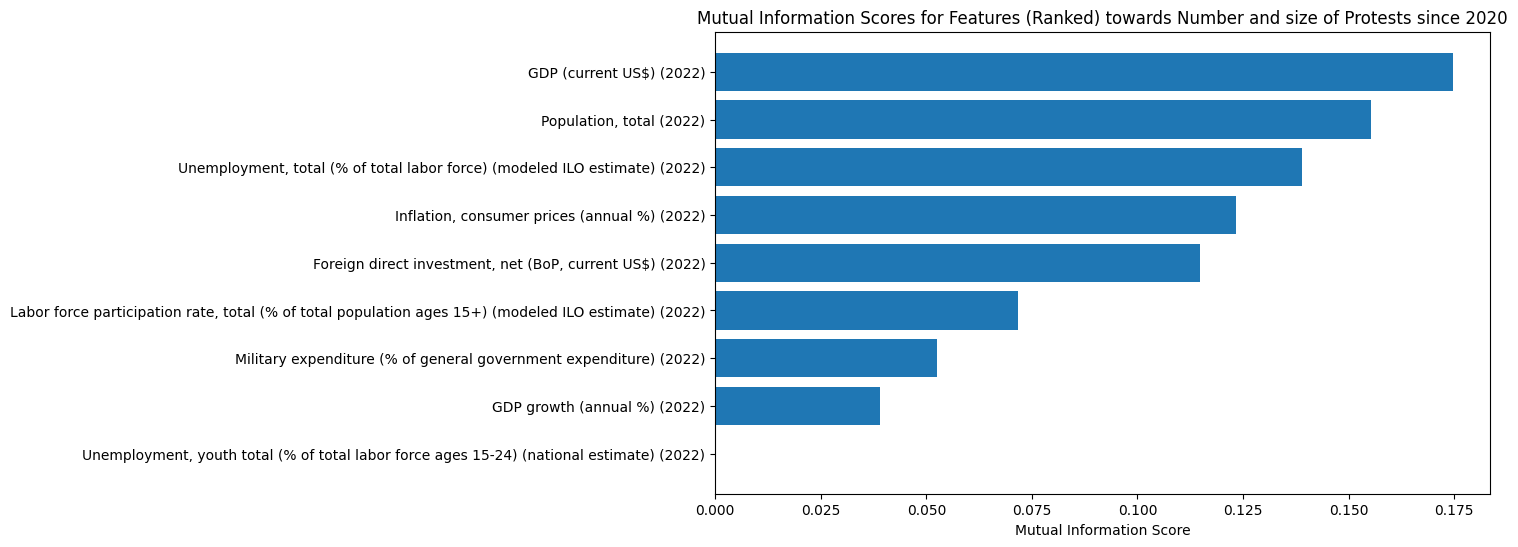

In [97]:
# Extract feature names and MI scores from the sorted list
sorted_features, mi_scores = zip(*sorted_feature_mi_protests)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), mi_scores, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Mutual Information Score')
plt.title('Mutual Information Scores for Features (Ranked) towards Number and size of Protests since 2020')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

### 4 - Feature importance to predict Protect with Random Forest 

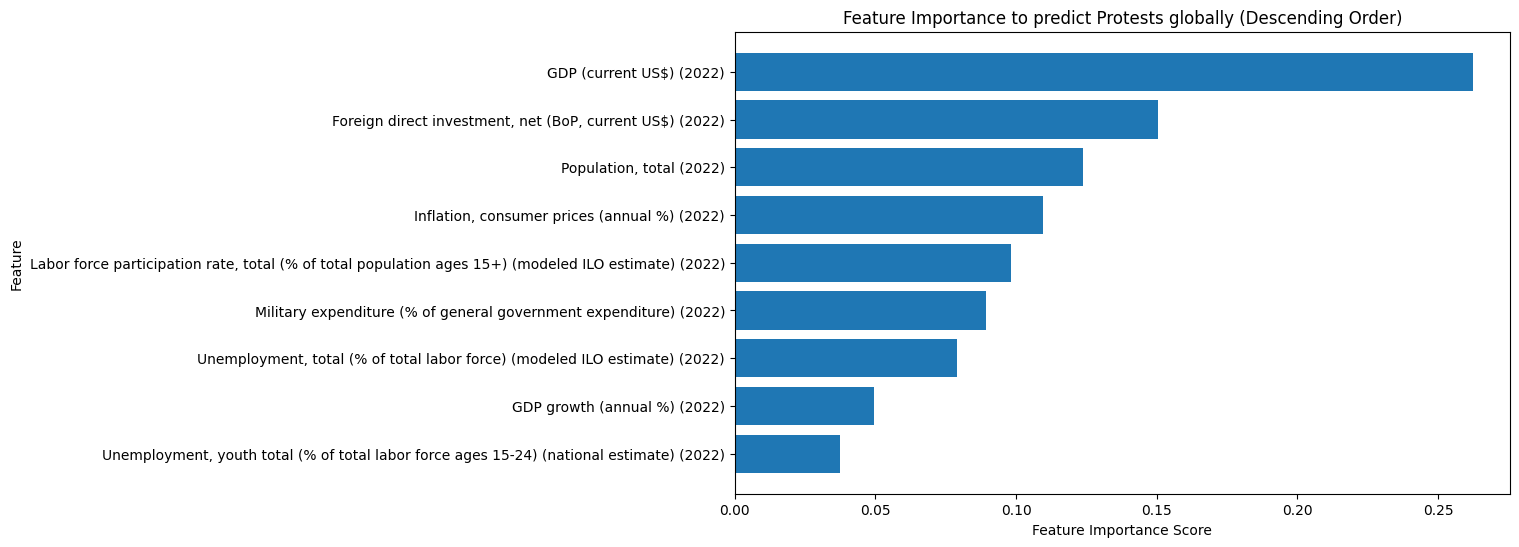

In [98]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming you have already loaded and preprocessed your data (X, y_protests)
# Split your data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_protests, test_size=0.2, random_state=42)

# Create and train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Sort feature importances and corresponding feature names in descending order
sorted_indices = (feature_importances).argsort()
sorted_features = [feature_columns[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a horizontal bar chart to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.ylabel('Feature')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance to predict Protests globally (Descending Order)')
plt.show()


In [113]:
# Initialize a dictionary to store feature importances for each subset
feature_columns = [
    'GDP (current US$) (2022)',
    'GDP growth (annual %) (2022)',
    'Population, total (2022)',
    'Foreign direct investment, net (BoP, current US$) (2022)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate) (2022)',
    'Unemployment, youth total (% of total labor force ages 15-24) (national estimate) (2022)',
    'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate) (2022)',
    'Military expenditure (% of general government expenditure) (2022)',
    #'Armed forces personnel (% of total labor force) (2022)',
    'Inflation, consumer prices (annual %) (2022)',
    #'Net migration (2022)',
    #'Life expectancy at birth, total (years) (2022)',
    #'Motivations', 'Duration'
]


In [134]:
freedom_ratings = countries['Freedom Rating (Status)'].unique()[1:]
freedom_ratings

array(['Not free', 'Partly free', 'Free'], dtype=object)

In [135]:
from sklearn.ensemble import RandomForestRegressor

def get_feature_importance_by_selected_ratings(data, target_feature, feature_columns, top_n=5):
    # Initialize a dictionary to store feature importances for each subset
    feature_importance_dict = {}
    
    # Get unique values of Freedom Rating (Status)
    freedom_ratings = data['Freedom Rating (Status)'].unique()[1:]
    
    # Loop over a selected range of values in Freedom Rating (Status)
    for rating in freedom_ratings:
               
        # Create a subset dataset for the current rating
        subset_df = data[data['Freedom Rating (Status)'] == rating]
        
        # Define feature matrix X and target variable y_protests for the subset
        X_subset = subset_df[feature_columns]
        X_subset = X_subset.fillna(X_subset.mean())  # Fill NaN values with the mean of the subset
        y_subset = subset_df[target_feature]
        
        # Train a Random Forest model on the subset dataset
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_subset, y_subset)
        
        # Extract feature importances
        feature_importances = rf_model.feature_importances_
        
        # Sort and select the top N features
        top_features_indices = feature_importances.argsort()[::-1][:top_n]
        top_features = [feature_columns[i] for i in top_features_indices]
        top_importances = feature_importances[top_features_indices]
        
        # Store the top features and their importances in the dictionary
        feature_importance_dict[rating] = (top_features, top_importances)
    
    return feature_importance_dict


In [136]:
# Example usage:
feature_importance_dict = get_feature_importance_by_rating(countries, 'Protests Since 2020', feature_columns)


ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required by RandomForestRegressor.

In [ ]:

# Plot the top 5 features for each Freedom Rating (Status)
plt.figure(figsize=(12, 8))

for rating, (top_features, top_importances) in feature_importance_dict.items():
    plt.barh(top_features, top_importances, label=f'Rating: {rating}')

plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importances for Predicting Protests Since 2020 (by Freedom Rating)')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### 5 - dimensionality reduction to understand Foreign direct investment, net (BoP, current US$) (2022)	

In [6]:
countries.sample(1)

,Unnamed: 0,alpha_3,alpha_2,name,official_name,geo_json,GDP (current US$) (2022),GDP growth (annual %) (2022),"Population, total (2022)","Unemployment, total (% of total labor force) (modeled ILO estimate) (2022)",...,Corruption motivation?,Size category,Protests with a significant outcome,"Large protests (Over 100,000 protesting)",Violent government response,Long protests (more than 3 months),Coronavirus-related protests,Capital city,End Date,Size protest
77,77,FSM,FM,"Micronesia, Federated States of",Federated States of Micronesia,NaN,4.270941e+08,-0.619575,114164.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

#drop useless columns
df_pca = countries.drop(['alpha_3','alpha_2','name','official_name','geo_json','Country_x',
                         'Country_y','Protest Name','Start Date','Triggers',
                         'Motivations','Peak Size','Outcomes','Size category',
                         'Capital city','End Date'
                        ],axis=1)

# Identify categorical and numerical columns
categorical_columns = ['Freedom Rating (Status)','Key Participants','Duration'] 
binary_columns = ['Active protests','Economic motivation?','Political motivation?',
                  'Corruption motivation?','Protests with a significant outcome',
                  'Large protests (Over 100,000 protesting)','Violent government response',
                  'Long protests (more than 3 months)','Coronavirus-related protests']  
numerical_columns = [col for col in df_pca.columns if col not in categorical_columns + binary_columns]

In [8]:
# Replace missing values with zeros for specific columns
# columns_to_replace_with_zeros = ['GDP (current US$) (2022)', 'GDP growth (annual %)',
#                                 'Population, total (2022)','Unemployment, total (% of total labor force) (modeled ILO estimate) (2022)',
#                                 'Foreign direct investment, net (BoP, current US$) (2022)',']
# df_pca[columns_to_replace_with_zeros] = df_pca[columns_to_replace_with_zeros].fillna(0)
df_pca = df_pca.fillna(0)

In [9]:
# Replace 0 with None in the 'Freedom Rating (Status)' column
df_pca['Freedom Rating (Status)'].replace(0, np.nan, inplace=True)
df_pca['Key Participants'].replace(0, np.nan, inplace=True)

In [10]:
df_pca['Freedom Rating (Status)'] = df_pca['Freedom Rating (Status)'].astype('category')
df_pca['Key Participants'] = df_pca['Key Participants'].astype('category')

In [11]:
# Convert columns to appropriate data types
df_pca['Duration'] = pd.to_numeric(df_pca['Duration'], errors='coerce')

In [12]:
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 29 columns):
 #   Column                                                                                                Non-Null Count  Dtype   
---  ------                                                                                                --------------  -----   
 0   Unnamed: 0                                                                                            249 non-null    int64   
 1   GDP (current US$) (2022)                                                                              249 non-null    float64 
 2   GDP growth (annual %) (2022)                                                                          249 non-null    float64 
 3   Population, total (2022)                                                                              249 non-null    float64 
 4   Unemployment, total (% of total labor force) (modeled ILO estimate) (2022)                        

In [13]:
mixed_data_type_columns = []

for column in df_pca.columns:
    data_types = df_pca[column].apply(type).unique()
    if len(data_types) > 1:
        mixed_data_type_columns.append(column)

print("Columns with mixed data types:", mixed_data_type_columns)

Columns with mixed data types: ['Freedom Rating (Status)', 'Key Participants']


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [15]:
# Define numerical and categorical columns
numerical_columns = df_pca.select_dtypes(include=['number']).columns.tolist()
categorical_columns = ['Freedom Rating (Status)']

# Define preprocessing steps for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('standard_scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent
    ('onehot', OneHotEncoder(drop='first'))  # 'drop' removes one category to avoid multicollinearity
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create a pipeline for preprocessing and PCA
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', PCA())])


In [43]:
# Fit the pipeline to your data
pipeline.fit(df_pca)

# Obtain the explained variance ratios from the PCA model
pca = pipeline.named_steps['pca']
explained_variance_ratios = pca.explained_variance_ratio_

In [45]:
# Access the fitted PCA object from the pipeline
# Get the components (principal axes) of the PCA
principal_components = pca.components_

# Get the importance scores (loadings) for each component
component_importance_scores = np.abs(principal_components).sum(axis=1)

# Get the names of the columns
column_names = df_pca.columns

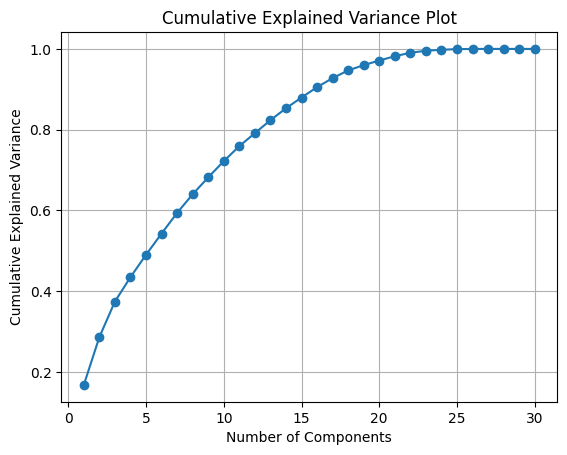

In [46]:
# Calculate the cumulative explained variance : shows the cumulative explained variance as you add more components
cumulative_explained_variance = np.cumsum(explained_variance_ratios)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid()
plt.show()

In [47]:
# Check the shape of principal_components and df_pca.columns
print("Shape of principal_components:", principal_components.shape)
print("Number of columns in df_pca:", len(df_pca.columns))


Shape of principal_components: (30, 30)
Number of columns in df_pca: 29


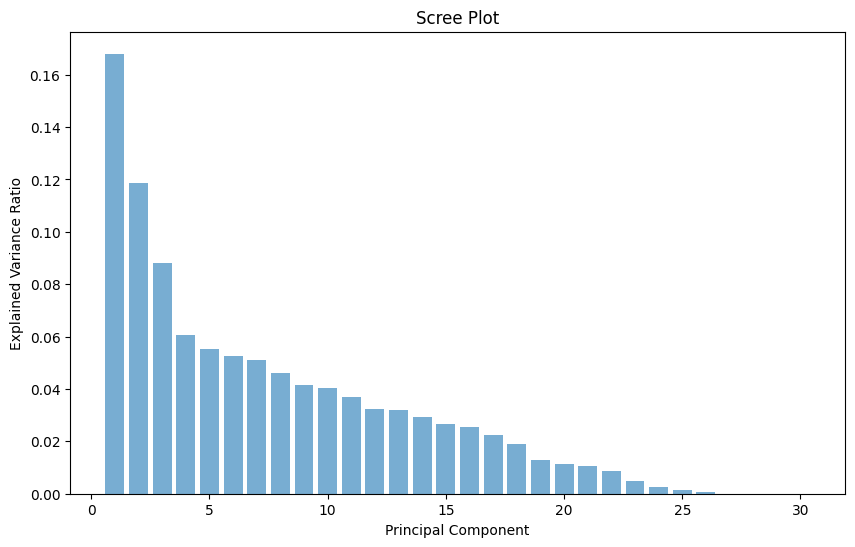

In [48]:
import matplotlib.pyplot as plt

# Plot the explained variance ratios :  shows the explained variance for each principal component
# Create a scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, alpha=0.6, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [49]:
len(component_importance_scores), len(column_names), len(principal_components)

(30, 29, 30)

In [50]:
component_importance_scores

array([4.50389311, 3.97109756, 3.98014862, 3.80222815, 3.82097604,
       3.80628053, 3.91325232, 3.28289479, 3.84630503, 3.7642061 ,
       3.96397058, 3.77578161, 4.24420946, 3.88319573, 3.58150145,
       4.05523927, 3.98733343, 3.63332427, 3.42178652, 3.93220129,
       3.93065452, 3.86922152, 2.47218808, 2.4319036 , 2.43802266,
       1.56028061, 1.95996461, 1.89501565, 1.68181336, 1.76081439])

C:\Users\Tis\Documents\Test\Projects\Python\DB\dbrock\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Tis\Documents\Test\Projects\Python\DB\dbrock\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Tis\Documents\Test\Projects\Python\DB\dbrock\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


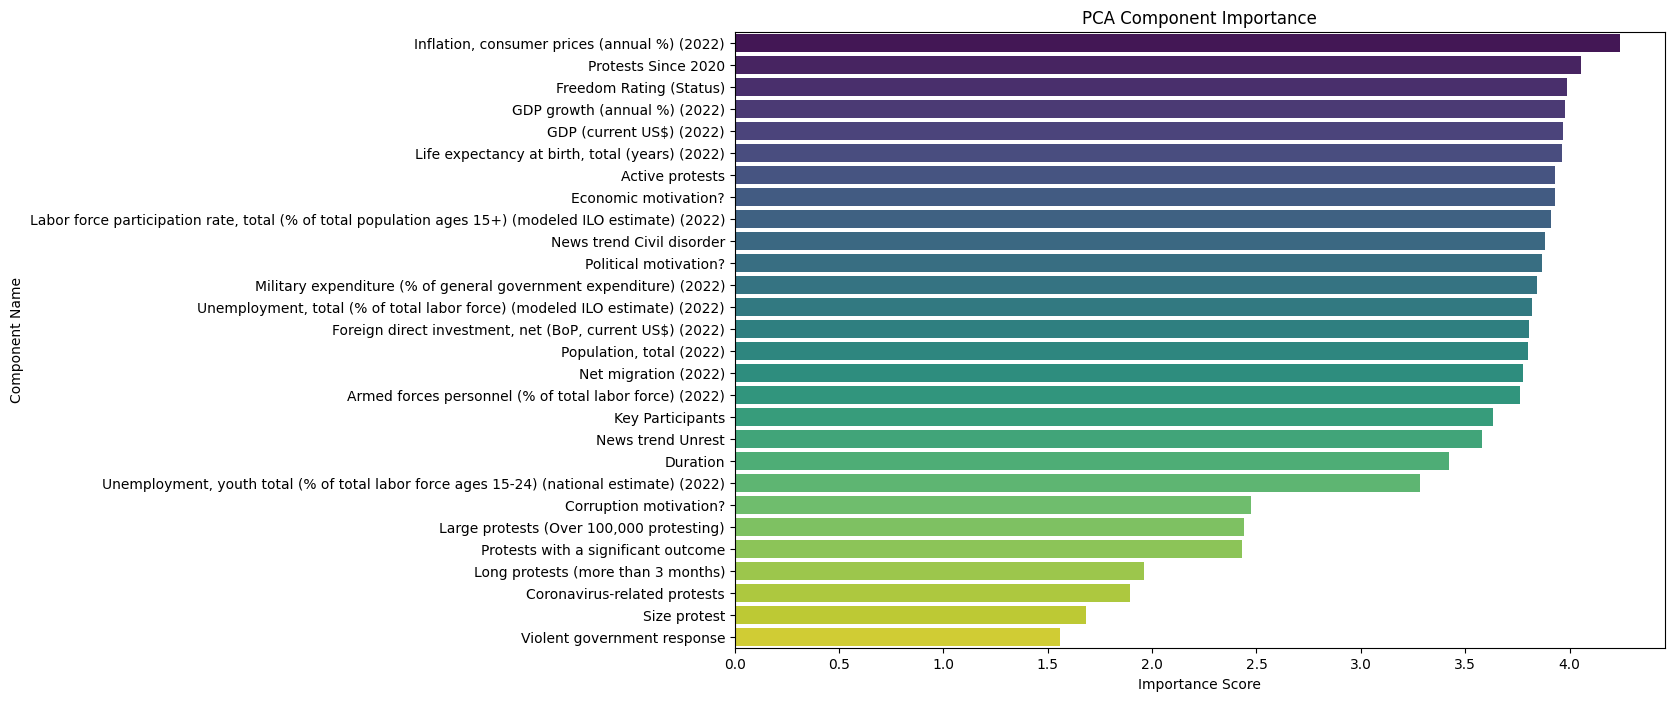

In [53]:
# Create a DataFrame to store component names and their importance scores
component_importance_df = pd.DataFrame({'Component': column_names[1:], 'Importance': component_importance_scores[1:-1]})

# Sort the DataFrame by importance scores (descending order)
component_importance_df = component_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot to visualize component importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Component', data=component_importance_df, palette='viridis')
plt.xlabel('Importance Score')
plt.ylabel('Component Name')
plt.title('PCA Component Importance')
plt.show()

In [ ]:
# Clean data by handling missing values and all col must be numerical, so encode categorical and handle outliers
# split dataset into train test
# select regression model : Decision Tree Regression, Random Forest Regression, or other non-linear regression models: Appropriate when the relationship is not strictly linear.
# The model will learn the relationship between the independent variables and the "Protest number."
# evaluate perf evaluation metrics for regression models include Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (coefficient of determination)
# examine feature importance: which independent variables have the most influence on the "Protest number."

### 5 - Clustering

In [ ]:
# Clustering: You can perform clustering techniques to group countries based on their correlation patterns. K-Means clustering or hierarchical clustering can help you identify countries with similar correlation profiles.

In [ ]:
# Feature Engineering: Create new features that represent the summary statistics of correlations for each country. For example, you could create features like "Mean Correlation," "Max Correlation," or "Number of Strong Correlations (above a certain threshold)" for each country.

In [ ]:
# Dimensionality Reduction: Apply dimensionality reduction techniques like Principal Component Analysis (PCA) to reduce the correlations to a lower-dimensional space. This can help in identifying patterns among countries in a more interpretable way.

In [ ]:
# Visualization: Create visualizations like heatmaps to display correlation patterns for each country. This can help you identify countries with strong positive or negative correlations among variables.

In [ ]:
# Hypothesis Testing: Conduct hypothesis tests to determine if the correlations for specific countries are significantly different from the overall population. For example, you can perform a t-test to compare the mean correlations of a specific country with the mean correlations of all countries.

In [ ]:
# Network Analysis: Treat the correlations as edges in a network graph and analyze the network properties. You can identify countries with a central role in the correlation network.